# Flood workflow

## Risk assessment methodology

Deterministic flood risk is calculated as a combination of flood extent maps of different return periods and flood damage (based on Rojas et al., 2013)

- River flood extent and water depth: available from the [Copernicus Land Monitoring Service](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) for different return periods. Flood extent map of 100m resolution  
- Land-use information: The land cover map is available from the [Copernicus Land Monitoring Service](https://land.copernicus.eu/pan-european/corine-land-cover)   
- Flood damage: assessed as a combination between flood extent/water depths and damage curve (available [here](https://publications.jrc.ec.europa.eu/repository/handle/JRC105688). For each pixel, the water depths are used as input in the damage curve to assess the damage, together with different land use and country.   
- Flood affected population is assessed by overlaying the [Global Human Settlement Population dataset](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop) with the flood inundation maps for a given return map. The data are available at different spatial resolutions (100 m to 1 km) and different time steps (1975 to 2030). Another potential population dataset with 100 m spatial resolution is available [here](https://doi.org/10.5281/zenodo.7885990). Future population projections are available from Wang et al. 2022 at 1 km spatial resolution [here](https://doi.org/10.6084/m9.figshare.19608594.v2)  

These are examples of possible datasets, the idea is that a user could apply the methodology even with their own data  

**Probabilistic assessment of flood damage** is calculated for different return periods (i.e. 2, 5, 10, 20, 50, 100, 250 and 500 years). In this way, damage-probability curves can be obtained at the grid cell by interpolating the damage estimates between the different recurrence intervals considered. The expected annual damages at a given grid cell due to river flooding are thus the integral of the damage-probability curve. Flood protection can be included in the expected annual damages estimation by truncating the damage-probability curves at the corresponding protection level (e.g. design flood with return period of 100 years). The integral of the remaining part after truncation quantifies the expected annual damages and expected annual population affected caused by river flooding considering flood protection up to the design flood.  
Similar to flood damages, population exposure probability functions can be derived for each grid cell within the modelled domain.  

## Preparation work

### Load libraries

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [damagescanner](https://damagescanner.readthedocs.io/en/latest/#) - To calculate the damage maps
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps
- [matplotlib](https://matplotlib.org/) - For plotting as well

In [1]:
import os
import pooch

import pandas as pd
import rasterio
from pathlib import Path
import rioxarray as rxr
import xarray as xr

from damagescanner.core import RasterScanner
from damagescanner.plot import damagemap_raster

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called notebook in the same directory where this notebook is saved.

In [2]:
workflow_folder = 'flood_workflow'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

### Download data

The data we are using is available as compressed ZIP files in the JRC data portal. 
Since there is no API to download this data, we can use **[pooch](https://www.fatiando.org/pooch/latest/index.html)** library to donwload and unzip the data.  

Pooch will check if the zip file already exists by comparing the hash of the file with what is stored in the default and only download it if it is not already there.

#### Flood data

First we download the flood data for 10, 20, 50, 100, 200 and 500 years.  

In the list of [pairs](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences) **return_periods**, first value is the return period, and second value is the [hash of the dataset](https://www.fatiando.org/pooch/latest/hashes.html).  

Next cell will:
- create the create the **data** folder inside the notebook folder
- [loop](https://wiki.python.org/moin/ForLoop) through all return periods and download and unzip each file in the data folder (if the data doesn't already exist).

Data for each return period can also be manually downloaded from [this link](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) in the JRC data portal.

In [3]:
data_dir = os.path.join(workflow_folder,'data')

In [ ]:
return_periods = [('010', '6dfba3cba22bf99fefb45e66963b8dbf7054e81b8a6b46258eff6ffda686d2a4'), 
                  ('020', 'a497725f7edf00ed01f3084e3d755b77294c53939b5f7ad5174f59c0331a5d34'), 
                  ('050', '47a804f617b0bbc9646ae3274e4959ba21edf4ef2bac778051f86ce7fcf4cde5'), 
                  ('100', 'cecda59c96d6dcd340a1ff2e82efc1caabd5c98d650b70fca5e802fd01872cae'),
                  ('200', '9988c310a306c8244fda542b6e5ea2956a5b98ffc06ed3104cef869443646533'),
                  ('500', 'a64803d8e31ca35bff0e386388d44b06674c78e3e8777e1d44a05098e0730268')]

for item in return_periods:
    return_period, khash = item
    url = f'https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/FLOODS/EuropeanMaps/floodMap_RP{return_period}.zip'
    pooch.retrieve(
        url=url,
        known_hash=khash,
        processor=pooch.Unzip(extract_dir=''),
        path=data_dir,
    )

KeyboardInterrupt: 

Note that now we have a directory **flood_workflow/data** where all the zip files and unzipped flood files are.  
We can list all the files in the **data_dir** using the os library.  

In [4]:
with os.scandir(data_dir) as entries:
    for entry in entries:
        print(entry.name)

1585990f3c153433b24dabddcc530fd4-floodMap_RP100.zip
4f561cff16a1e03872ba13730185269d-floodMap_RP020.zip
7740e788f13e732a18c6030861dcfd1f-floodMap_RP010.zip
9be95e8ef48a328d83d36a6925a12a49-floodMap_RP050.zip
b46eeb1cb14dd2e5f400d075fc0b1be1-floodMap_RP200.zip
curves.csv
e99fd2aedd715d6d630fbe89da7c7462-JRC_LUISA_Output_land_use_ref_2014.zip
floodmap_EFAS_RP010_C.tfw
floodmap_EFAS_RP010_C.tif
floodmap_EFAS_RP010_C.tif.aux.xml
floodmap_EFAS_RP010_C.tif.ovr
floodmap_EFAS_RP010_C.tif.xml
floodmap_EFAS_RP020_C.tfw
floodmap_EFAS_RP020_C.tif
floodmap_EFAS_RP020_C.tif.aux.xml
floodmap_EFAS_RP020_C.tif.ovr
floodmap_EFAS_RP020_C.tif.xml
floodmap_EFAS_RP050_C.tfw
floodmap_EFAS_RP050_C.tif
floodmap_EFAS_RP050_C.tif.aux.xml
floodmap_EFAS_RP050_C.tif.ovr
floodmap_EFAS_RP050_C.tif.xml
floodmap_EFAS_RP100_C.tfw
floodmap_EFAS_RP100_C.tif
floodmap_EFAS_RP100_C.tif.aux.xml
floodmap_EFAS_RP100_C.tif.ovr
floodmap_EFAS_RP100_C.tif.xml
floodmap_EFAS_RP200_C.tfw
floodmap_EFAS_RP200_C.tif
floodmap_EFAS_RP200_C

#### Land-use information
Next we need the information on land use.  
We will download it from the JRC data portal.
:::{note}
Once the data is downloaded and unzipped, Pooch will list the content of the directory with the data.
:::

In [5]:
url = 'http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/EUROPE/Basemaps/2018/VER2021-03-24/LUISA_basemap_020321_50m.tif'
pooch.retrieve(
    url=url,
    known_hash=None,
    path=data_dir,
    fname = 'LUISA_basemap_020321_50m.tif'
)

'C:\\Users\\buskop\\OneDrive - Stichting Deltares\\Documents\\GitHub\\FLOODS\\flood_workflow\\data\\LUISA_basemap_020321_50m.tif'

#### Damage curves

We will download damage curves files from [DamageScanner library](https://github.com/VU-IVM/DamageScanner)


<Axes: >

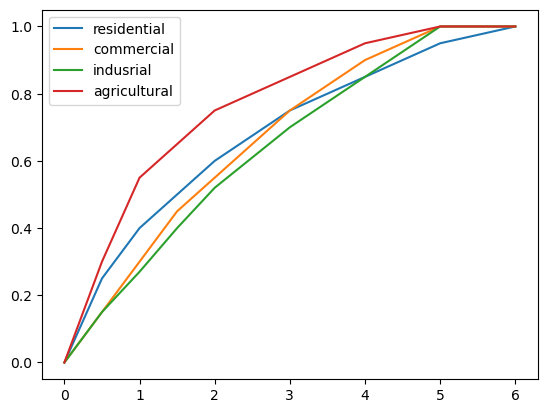

In [12]:
# import damage curves of the JRC
JRC_curves = pd.read_csv('JRC_damage_curves.csv', index_col=0)  
JRC_curves.plot()

## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

### Flood data
We have downloaded river flood hazard map of Europe and the Mediterranean Basin Region.    
The maps depict flood prone areas for river flood events for six different flood frequencies (from 1-in-10-years to 1-in-500-years). The extent comprises most of the geographical Europe and all the river basins entering the Mediterranean and Black Seas in the Caucasus, Middle East and Northern Africa countries.  
Cell values indicate water depth (in m).  
The maps can be used to assess the exposure of population and economic assets to river floods, and to perform flood risk assessments.  

All the downloaded files are stored in our **data_dir** folder, with filenames starting with: **floodmap_EFAS_RP** folowed by the number of years for the return period.  
First we can explore one of them.

:::{tip} Explore the file content
Fell free to explore the content and structure of the datasets.  
Note the coordinates, dimensions and attributes!
:::

:::{hint} Find the information about spatial references, statistics 👇
:class: dropdown
👋 Click on **spatial_ref** 📄 _show/hide attributes_ to see the spatial information  
👋 Look at _STATISTICS_ attributes to find minimum, maximum and other statistics

:::

In [9]:
filename_flood_200 = f'{data_dir}/floodmap_EFAS_RP200_C.tif'

flood_200 = rxr.open_rasterio(filename_flood_200)
flood_200

<xarray.DataArray (band: 1, y: 45242, x: 63976)>
[2894402192 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 9.19e+05 9.19e+05 9.192e+05 ... 7.316e+06 7.316e+06
  * y            (y) float64 5.441e+06 5.44e+06 5.44e+06 ... 9.166e+05 9.164e+05
    spatial_ref  int32 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  8.163502234701596
    STATISTICS_MAXIMUM:      276.02301025391
    STATISTICS_MEAN:         2.2657492941088
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       2.8571843193434
    _FillValue:              -3.402823e+38
    scale_factor:            1.0
    add_offset:              0.0

### Land use data
All the Land use data is extracted in the LUISA_LU directory inside our data_dir folder.  
When we list it, using the os Python library, we can see that we have several files.  

First we have the land use projections for 2010, 2020, 2030, 2040 and 2050. We also have files labeled with **legend** that provide metadata and mapping between different land use classes.

In [10]:
with os.scandir(f'{data_dir}') as entries:
    for entry in entries:
        print(entry.name)

1585990f3c153433b24dabddcc530fd4-floodMap_RP100.zip
4f561cff16a1e03872ba13730185269d-floodMap_RP020.zip
7740e788f13e732a18c6030861dcfd1f-floodMap_RP010.zip
9be95e8ef48a328d83d36a6925a12a49-floodMap_RP050.zip
b46eeb1cb14dd2e5f400d075fc0b1be1-floodMap_RP200.zip
curves.csv
e99fd2aedd715d6d630fbe89da7c7462-JRC_LUISA_Output_land_use_ref_2014.zip
floodmap_EFAS_RP010_C.tfw
floodmap_EFAS_RP010_C.tif
floodmap_EFAS_RP010_C.tif.aux.xml
floodmap_EFAS_RP010_C.tif.ovr
floodmap_EFAS_RP010_C.tif.xml
floodmap_EFAS_RP020_C.tfw
floodmap_EFAS_RP020_C.tif
floodmap_EFAS_RP020_C.tif.aux.xml
floodmap_EFAS_RP020_C.tif.ovr
floodmap_EFAS_RP020_C.tif.xml
floodmap_EFAS_RP050_C.tfw
floodmap_EFAS_RP050_C.tif
floodmap_EFAS_RP050_C.tif.aux.xml
floodmap_EFAS_RP050_C.tif.ovr
floodmap_EFAS_RP050_C.tif.xml
floodmap_EFAS_RP100_C.tfw
floodmap_EFAS_RP100_C.tif
floodmap_EFAS_RP100_C.tif.aux.xml
floodmap_EFAS_RP100_C.tif.ovr
floodmap_EFAS_RP100_C.tif.xml
floodmap_EFAS_RP200_C.tfw
floodmap_EFAS_RP200_C.tif
floodmap_EFAS_RP200_C

Let's explore one of the land use projection files, for example 2030 projection (2030_LUISA_LU).  
We will use rioxarray to open the file and list its content.

In [11]:
filename_land_use = f'{data_dir}/LUISA_basemap_020321_50m.tif'

land_use = rxr.open_rasterio(filename_land_use)
land_use

<xarray.DataArray (band: 1, y: 92000, x: 130000)>
[11960000000 values with dtype=int32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 9e+05 9.001e+05 9.001e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 5.5e+06 5.5e+06 5.5e+06 ... 9.001e+05 9e+05
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

## Process the data

If we have a closer look at the x and y dimensions of the datasets, we can see that the data has different resolutions. Flood extent maps are at 100 m resolution, while land use data is at 1km. We can use xarray to get them to the same resolution.  

But first we need to clip them to the same area, so we don't interpolate the whole global field.   

For this we use the rioxarray library again.  
**minx** and **maxx** are longitudes, and **miny** and **maxy** are latitudes of the bounding box.  

In this example we are clipping the bounding box around city of Zilina in Slovakia.

In [49]:
xmin=18
ymin=48
xmax=20
ymax=50

bbox = [xmin, ymin, xmax, ymax]

Text(0.5, 1.0, 'LUISA Land Cover for the defined area')

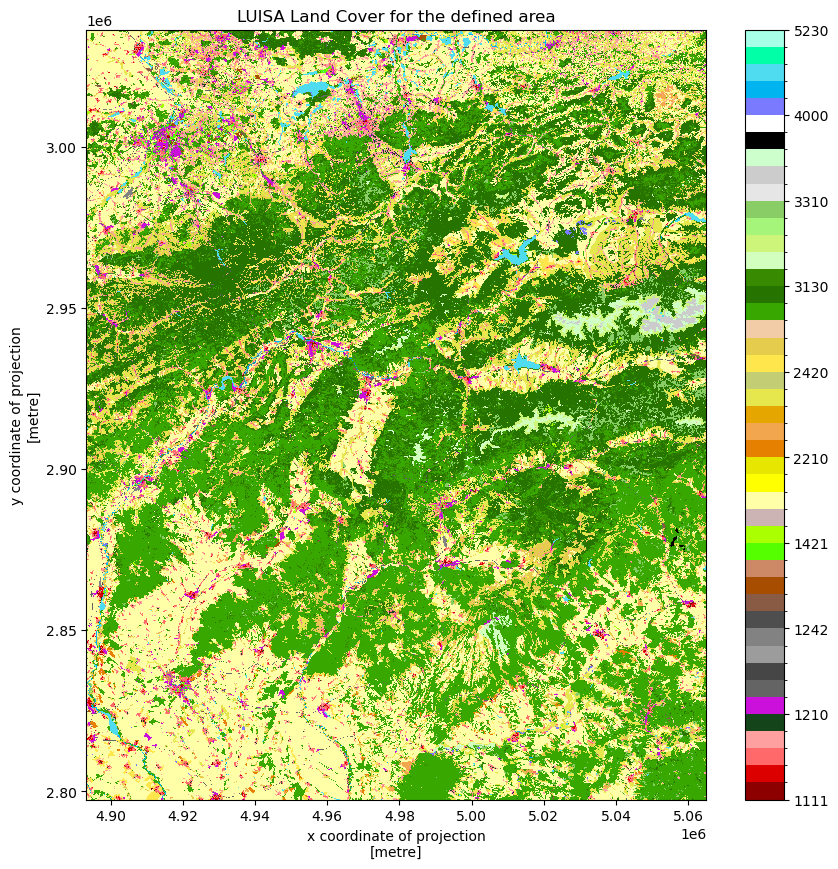

In [50]:
land_use.rio.write_crs(3035, inplace=True)

land_use_small_area = land_use.rio.clip_box(*bbox,
                                        crs="EPSG:4326")

LUISA_values = [1111,1121, 1122, 1123, 1130,
                1210, 1221, 1222, 1230, 1241,
                1242, 1310, 1320, 1330, 1410,
                1421, 1422, 2110, 2120, 2130,
                2210, 2220, 2230, 2310, 2410,
                2420, 2430, 2440, 3110, 3120,
                3130, 3210, 3220, 3230, 3240,
                3310, 3320, 3330, 3340, 3350,
                4000, 5110, 5120, 5210, 5220,
                5230]

LUISA_colors = ["#8c0000", "#dc0000", "#ff6969", "#ffa0a0", "#14451a",
                "#cc10dc", "#646464", "#464646", "#9c9c9c", "#828282",
                "#4e4e4e", "#895a44", "#a64d00", "#cd8966", "#55ff00",
                "#aaff00", "#ccb4b4", "#ffffa8", "#ffff00", "#e6e600",
                "#e68000", "#f2a64d", "#e6a600", "#e6e64d", "#c3cd73",
                "#ffe64d", "#e6cc4d", "#f2cca6", "#38a800", "#267300",
                "#388a00", "#d3ffbe", "#cdf57a", "#a5f57a", "#89cd66",
                "#e6e6e6", "#cccccc", "#ccffcc", "#000000", "#ffffff",
                "#7a7aff", "#00b4f0", "#50dcf0", "#00ffa6", "#a6ffe6",
                "#e6f2ff"]


# plot the land use
land_use_small_area.plot(levels=LUISA_values, colors=LUISA_colors, figsize=(10,10))
plt.title('LUISA Land Cover for the defined area')

In [51]:
land_use_small_area

<xarray.DataArray (band: 1, y: 4778, x: 3435)>
[16412430 values with dtype=int32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.893e+06 4.893e+06 ... 5.065e+06 5.065e+06
  * y            (y) float64 3.036e+06 3.036e+06 ... 2.798e+06 2.797e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0

In [52]:
flood_200_small_area = flood_200.rio.clip_box(
    *bbox,
    crs="EPSG:4326",
)
flood_200_small_area

<xarray.DataArray (band: 1, y: 2390, x: 1718)>
[4106020 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.893e+06 4.893e+06 ... 5.065e+06 5.065e+06
  * y            (y) float64 3.036e+06 3.036e+06 ... 2.798e+06 2.797e+06
    spatial_ref  int32 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  8.163502234701596
    STATISTICS_MAXIMUM:      276.02301025391
    STATISTICS_MEAN:         2.2657492941088
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       2.8571843193434
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              -3.402823e+38

#### Interpolate the land use data array

Next we need to interpolate the flood data into the land use map grid in order to be able to calculate the damage map.  
We can use the xarray [**interp_like()**](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.interp_like.html) function, that will interpolate the land use data into flood grid.  

Since we don't really want interpolate the values, we are using method **'nearest'**, to assing the values of the nearest grid points.

In [53]:
flood_200_small_area

<xarray.DataArray (band: 1, y: 2390, x: 1718)>
[4106020 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.893e+06 4.893e+06 ... 5.065e+06 5.065e+06
  * y            (y) float64 3.036e+06 3.036e+06 ... 2.798e+06 2.797e+06
    spatial_ref  int32 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  8.163502234701596
    STATISTICS_MAXIMUM:      276.02301025391
    STATISTICS_MEAN:         2.2657492941088
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       2.8571843193434
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              -3.402823e+38

In [54]:
from rasterio.enums import Resampling

flood_200_small_area_matched  = flood_200_small_area.rio.reproject_match(land_use_small_area, resampling=Resampling.nearest)
flood_200_small_area_matched

<xarray.DataArray (band: 1, y: 4778, x: 3435)>
array([[[-3.402823e+38, -3.402823e+38, -3.402823e+38, ...,
         -3.402823e+38, -3.402823e+38, -3.402823e+38],
        [-3.402823e+38, -3.402823e+38, -3.402823e+38, ...,
         -3.402823e+38, -3.402823e+38, -3.402823e+38],
        [-3.402823e+38, -3.402823e+38, -3.402823e+38, ...,
         -3.402823e+38, -3.402823e+38, -3.402823e+38],
        ...,
        [-3.402823e+38, -3.402823e+38, -3.402823e+38, ...,
         -3.402823e+38, -3.402823e+38, -3.402823e+38],
        [-3.402823e+38, -3.402823e+38, -3.402823e+38, ...,
         -3.402823e+38, -3.402823e+38, -3.402823e+38],
        [-3.402823e+38, -3.402823e+38, -3.402823e+38, ...,
         -3.402823e+38, -3.402823e+38, -3.402823e+38]]], dtype=float32)
Coordinates:
  * x            (x) float64 4.893e+06 4.893e+06 ... 5.065e+06 5.065e+06
  * y            (y) float64 3.036e+06 3.036e+06 ... 2.798e+06 2.797e+06
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  8.163502234701596
    STATISTICS_MAXIMUM:      276.02301025391
    STATISTICS_MEAN:         2.2657492941088
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       2.8571843193434
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              -3.402823e+38

In [55]:
flood_200_small_area_matched.rio.resolution()

(50.0, -50.0)

In [56]:
flood_200_small_area_matched.max()

<xarray.DataArray ()>
array(25.167, dtype=float32)
Coordinates:
    spatial_ref  int32 0

For now we save them as tif so DamageScanner can use them as input. This will change very soon.

In [57]:
with rasterio.open(f'{data_dir}/flood_200_small_area_matched.tif', 'w', driver='GTiff', height=flood_200_small_area_matched.shape[1], width=flood_200_small_area_matched.shape[2],
                   count=1, dtype=str(flood_200_small_area_matched.dtype), crs=flood_200_small_area_matched.rio.crs,
                   transform=flood_200_small_area_matched.rio.transform()) as dst:
    # Write the data array values to the rasterio dataset
    dst.write(flood_200_small_area_matched.values)


In [58]:
with rasterio.open(f'{data_dir}/land_use_small_area.tif', 'w', driver='GTiff', height=land_use_small_area.shape[1], width=land_use_small_area.shape[2],
                   count=1, dtype=str(land_use_small_area.dtype), crs=land_use_small_area.rio.crs,
                   transform=land_use_small_area.rio.transform()) as dst:
    # Write the data array values to the rasterio dataset
    dst.write(land_use_small_area.values)

In [36]:
import pandas as pd
import openpyxl

LUISA_info_damage_curve = pd.read_excel('LUISA_damage_info_curves.xlsx', index_col=0)
# get the maxdamage for reconstruction
maxdam = pd.DataFrame(LUISA_info_damage_curve['total €/m²'])
maxdam.to_csv(f'{data_dir}/maxdam_luisa.csv')
maxdam.head(10)

,total €/m²
Land use code,
1111,495.880646
1121,354.200461
1122,212.520277
1123,63.756083
1130,0.000000
1210,318.780415
1221,23.613364
1222,495.880646
1230,212.520277


<Axes: >

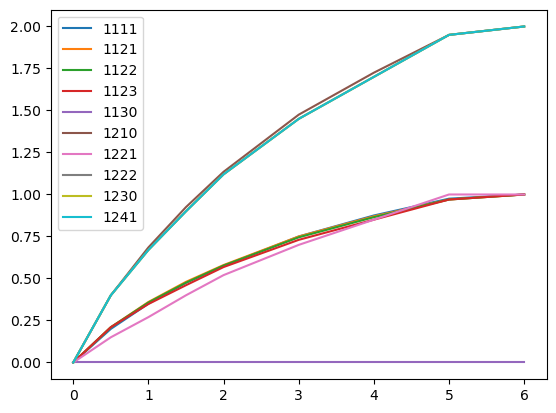

In [37]:
# create a new dataframe for damage_curves_luisa where wind and landuse classes are used
damage_curves_luisa = JRC_curves.copy()
# drop all columns
damage_curves_luisa.drop(damage_curves_luisa.columns, axis=1, inplace=True)

building_types = ['residential', 'commercial', 'industrial', 'agricultural']

# for each land use class in maxdamage create a new damage curve
for landuse in maxdam.index:
    # find the ratio of building types in the class
    ratio = LUISA_info_damage_curve.loc[landuse, building_types].values

    # new curve
    damage_curves_luisa[landuse] =  ratio[0] * JRC_curves.iloc[:,0] + \
                                    ratio[1] * JRC_curves.iloc[:,1] + \
                                    ratio[2] * JRC_curves.iloc[:,2] + \
                                    ratio[3] * JRC_curves.iloc[:,3]

    
damage_curves_luisa.iloc[:,0:10].plot()

In [41]:
LUISA_info_damage_curve.loc[maxdam.index[0], building_types].values

array([0.5, 0.5, 0.0, 0], dtype=object)

## Calculate the damage using DamageScanner library

Some text about DamageScanner library, link to the documentation etc.

Also explanation what input we will use and what it will return to us as output.

In [42]:
inun_map = os.path.join(data_dir,'flood_200_small_area_matched.tif')
landuse_map = os.path.join(data_dir,'land_use_small_area.tif')
curve_path = os.path.join(data_dir,'curves.csv')
maxdam_path = os.path.join(data_dir,'maxdam_luisa.csv')

In [43]:
import numpy as np
loss_df = RasterScanner(landuse_map,inun_map,curve_path,maxdam_path, save = True, nan_value = None, output_path = '.', scenario_name= f'{data_dir}/scenario2',  dtype = np.int64)

In [44]:
loss_df[0]

,damages
landuse,
1111,510132007
1121,1351840064
1122,3282731806
1123,3174218975
1130,0
1210,6639790243
1221,365222441
1222,0
1230,0


## Plot the results

Now we plot the damages.  
The values are wrong. But this is just a placeholder

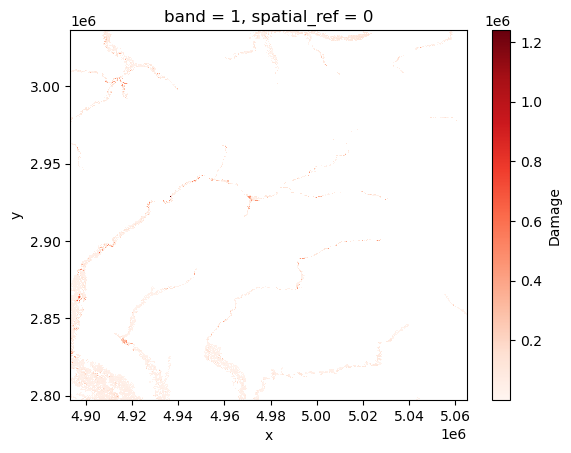

In [45]:
import contextily as ctx

damagemap = rxr.open_rasterio(f'{data_dir}/scenario2_damagemap.tif')

# from damage select values > 0
damagemap = damagemap.where(damagemap > 0)
damagemap.plot(cmap='Reds', cbar_kwargs={'label': "Damage"})

## Conclusions

Some text about conclusions and lessons learned

## Contributors
authors, links to libraries documentation, references etc